In [1]:
import matplotlib.pyplot as plt
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

In [2]:
import pandas as pd
#Pipline Imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from google.cloud import storage
from PIL import Image
import io
import os
import numpy as np

In [3]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

2025-06-10 14:27:07.017453: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-10 14:27:07.621003: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-10 14:27:08.226997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749565628.984457    7909 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749565629.208848    7909 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749565630.246128    7909 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [4]:
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate

In [6]:
import sys
import os

# Add parent directory to Python path
sys.path.append(os.path.abspath("../skin_scan"))

# Now you can import the module
import preprocessing
from data import get_metadata_from_bq

In [7]:
metadata = get_metadata_from_bq()

In [8]:
metadata.shape

(10015, 8)

In [9]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,index
0,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,4349
1,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity,4263
2,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,4217
3,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,3587
4,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest,1451


## Processing metadata

In [56]:
# Split into nv and non-nv rows
nv_rows = metadata[metadata['dx'] == 'nv']
non_nv_rows = metadata[metadata['dx'] != 'nv']

# Drop duplicates from nv rows based on lesion_id (keeping the first occurrence)
nv_deduped = nv_rows.drop_duplicates(subset='lesion_id', keep='first')

# Combine back
metadata_cleaned = pd.concat([nv_deduped, non_nv_rows], ignore_index=True)

In [57]:
processed_metadata = preprocessing.preprocess_metadata(metadata_cleaned)

In [58]:
processed_metadata.shape

(8496, 6)

In [59]:
processed_metadata_small = processed_metadata

## Adding images

In [60]:
client = storage.Client()
bucket = client.bucket("skin_scan_mohnatz")
blobs = bucket.list_blobs(prefix="train_all_images/")
images = [blob.name for blob in blobs if blob.name.lower().endswith(".jpg")]

In [61]:
resized_array = []

In [62]:
for name in processed_metadata_small.image_id:
    for image in images:
        if image.endswith(f"{name}.jpg"):
            blob = bucket.blob(image)
            image_bytes = blob.download_as_bytes()
            img = Image.open(io.BytesIO(image_bytes))
            img = img.resize((96, 96))
            resized_array.append(np.array(img))

In [64]:
X_images = np.array(resized_array)

In [65]:
X_images.shape

(8496, 96, 96, 3)

In [66]:
X_images_copy = X_images.copy()

In [67]:
X_images = X_images/255

In [69]:
round(processed_metadata_small.dx.value_counts(normalize=True)*100,1)

dx
nv       61.5
mel      13.0
bkl      12.7
bcc       6.0
akiec     3.8
vasc      1.7
df        1.4
Name: proportion, dtype: float64

In [76]:
#Pipline Imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from PIL import Image
import io
import os
import numpy as np
import joblib
import json
from io import BytesIO
from google.cloud import storage

In [77]:
def create_X_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    age_pipeline = Pipeline([('scaler', MinMaxScaler())])
    cat_pipeline = Pipeline([('ohe', OneHotEncoder(sparse_output=False, drop='first'))])
    preprocessor = ColumnTransformer([
    ( 'age', age_pipeline, ['age']),
    ('cat', cat_pipeline,['sex','localization'])
    ])
    array = preprocessor.fit_transform(df)
    save_preprocessor_to_gcs(preprocessor)
    return array

In [78]:
BUCKET_NAME = "skin_scan_mohnatz"
BLOB_PATH = "models/preprocessor_joblib"
LOCAL_REGISTRY_PATH = "preprocessing_pipeline"

def save_preprocessor_to_gcs(preprocessor: Pipeline):
    """
    Save a scikit-learn preprocessor locally and upload it to GCS.
    """
    client = storage.Client()
    bucket = client.bucket(BUCKET_NAME)

    # Ensure local directory exists
    os.makedirs(LOCAL_REGISTRY_PATH, exist_ok=True)
    local_path = os.path.join(LOCAL_REGISTRY_PATH, os.path.basename(BLOB_PATH))

    try:
        # Save model locally (just once!)
        joblib.dump(preprocessor, local_path)
        print(f"✅ Preprocessor saved locally at {local_path}")

        # Upload to GCS
        blob = bucket.blob(BLOB_PATH)
        blob.upload_from_filename(local_path)
        print(f"✅ Preprocessor uploaded to GCS at gs://{BUCKET_NAME}/{BLOB_PATH}")

    except Exception as e:
        print(f"❌ Failed to save model to GCS: {e}")

In [79]:
create_X_pipeline(processed_metadata_small)

✅ Preprocessor saved locally at preprocessing_pipeline/preprocessor_joblib
✅ Preprocessor uploaded to GCS at gs://skin_scan_mohnatz/models/preprocessor_joblib


array([[0.52941176, 1.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.58823529, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.64705882, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [1.        , 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.82352941, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.64705882, 1.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [84]:
X_metadata, y = preprocessing.prepare_data_for_model(processed_metadata_small)

✅ Preprocessor downloaded from GCS to preprocessing_pipeline/preprocessor_joblib
✅ Preprocessor successfully loaded from local file


In [85]:
X_metadata.shape

(8496, 15)

In [86]:
y.shape

(8496, 7)

In [87]:
X_images.shape

(8496, 96, 96, 3)

## Model architecture

In [91]:
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Dropout

In [103]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, concatenate
from tensorflow.keras.models import Model

# Image Branch
image_input = Input(shape=(96, 96, 3))
cnn = Conv2D(16, (6, 6), activation='relu')(image_input)
cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
cnn = Dropout(0.1)(cnn)

cnn = Conv2D(32, (3, 3), activation='relu')(cnn)
cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
cnn = Dropout(0.15)(cnn)

cnn = Flatten()(cnn)
cnn = Dense(64, activation='relu')(cnn)
cnn = Dropout(0.25)(cnn)
cnn = Dense(32, activation='relu')(cnn)

# Metadata Branch
meta_input = Input(shape=(15,))
dln = Dense(16, activation='relu')(meta_input)
dln = Dropout(0.15)(dln)

# Combined Final Layers
combined_layers = concatenate([cnn, dln])
x = Dense(32, activation='relu')(combined_layers)
output = Dense(7, activation='softmax')(x)

# Define Model
test_model = Model(inputs=[image_input, meta_input], outputs=output)

In [104]:
test_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy","recall"])

In [105]:
test_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 91, 91,    │      1,744 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 45, 45,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 45, 45,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 43, 43,    │      4,640 │ dropout_4[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 21, 21,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 21, 21,    │          0 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 14112)     │          0 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │    903,232 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │        256 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 16)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 48)        │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      1,568 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 7)         │        231 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 913,751 (3.49 MB)

 Trainable params: 913,751 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
es = EarlyStopping(patience=10, restore_best_weights=True)

## Training the model

In [107]:
X_combined = list(zip(X_images, X_metadata))

X_combined_train, X_combined_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.3, random_state=42, stratify=y
)

# Unzip after the split
X_images_train, X_metadata_train = zip(*X_combined_train)
X_images_test, X_metadata_test = zip(*X_combined_test)

# Convert back to arrays if needed
import numpy as np
X_images_train = np.array(X_images_train)
X_images_test = np.array(X_images_test)
X_metadata_train = np.array(X_metadata_train)
X_metadata_test = np.array(X_metadata_test)


In [108]:
X_images_train.shape

(5947, 96, 96, 3)

In [109]:
X_metadata_train.shape

(5947, 15)

In [110]:
y_train.shape

(5947, 7)

In [111]:
history = test_model.fit([X_images_train, X_metadata_train], y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[es])

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.5870 - loss: 1.2209 - recall: 0.4261 - val_accuracy: 0.6487 - val_loss: 1.0400 - val_recall: 0.4126
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6575 - loss: 1.0028 - recall: 0.4839 - val_accuracy: 0.6597 - val_loss: 0.9425 - val_recall: 0.4622
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6915 - loss: 0.9197 - recall: 0.5253 - val_accuracy: 0.6748 - val_loss: 0.9290 - val_recall: 0.4630
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6788 - loss: 0.8945 - recall: 0.5247 - val_accuracy: 0.6840 - val_loss: 0.9005 - val_recall: 0.4714
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.6725 - loss: 0.8860 - recall: 0.5309 - val_accuracy: 0.6908 - val_loss: 0.8412 - val_recall: 0.5630
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.6857 - loss: 0.8521 - recall: 0.5491 - val_accuracy: 0.6849 - val_loss: 0.8587 - val_recall

## Evaluation of the model

In [112]:
test_model.evaluate([X_images_test,X_metadata_test],y_test)

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7337 - loss: 0.6905 - recall: 0.6569


[0.7078748941421509, 0.7340133190155029, 0.6512357592582703]

In [147]:
test_model.save("96_96_metadata_friday_model.keras")

In [148]:
from google.cloud import storage

# Set these before running
bucket_name = "skin_scan_mohnatz"
source_file_name = "96_96_metadata_friday_model.keras"
destination_blob_name = "models/96_96_metadata_friday_model.keras"  # Path in the bucket

# Initialise client (uses default credentials from your environment)
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)

# Upload
blob.upload_from_filename(source_file_name)

print(f"Uploaded {source_file_name} to gs://{bucket_name}/{destination_blob_name}")

Uploaded 96_96_metadata_friday_model.keras to gs://skin_scan_mohnatz/models/96_96_metadata_friday_model.keras


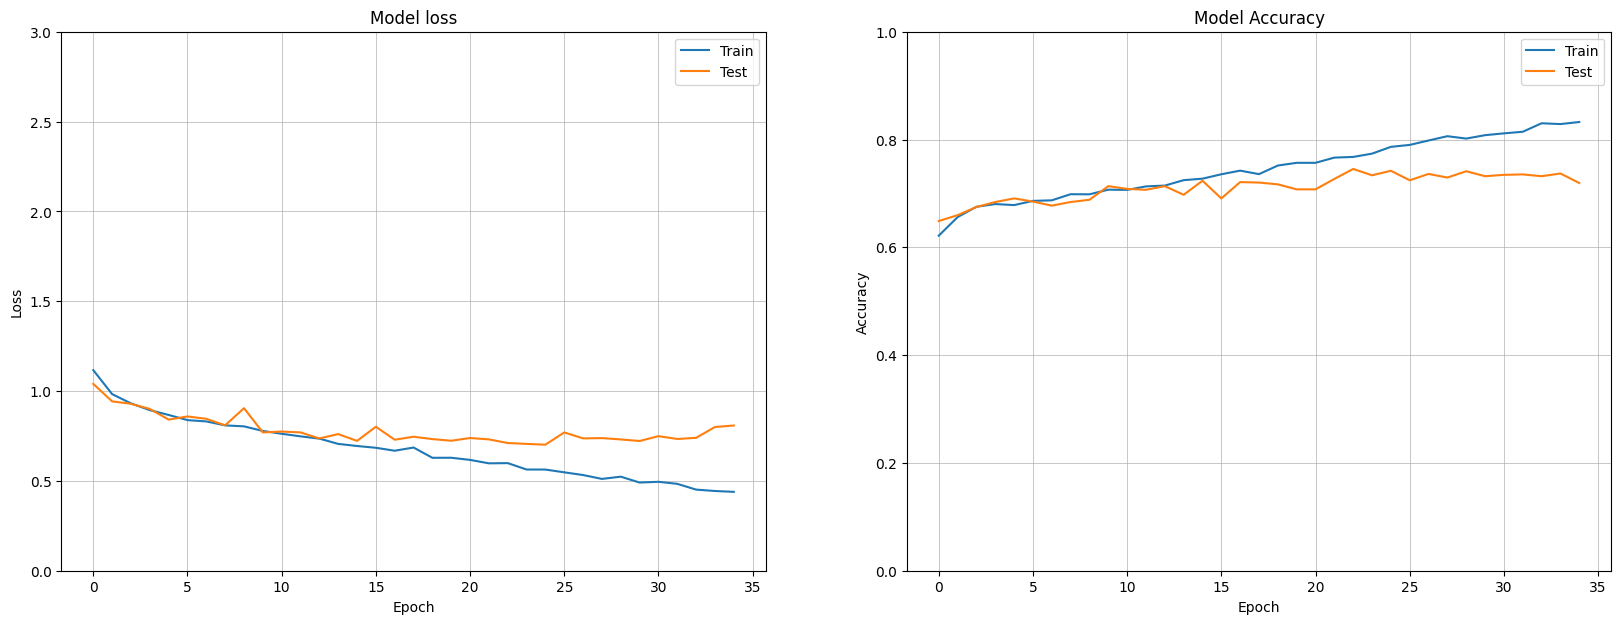

In [113]:
plot_loss_accuracy(history)

## Model architecture - padding

In [141]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, concatenate
from tensorflow.keras.models import Model

# Image Branch
image_input = Input(shape=(96, 96, 3))
cnn = Conv2D(16, (6, 6), padding="same", activation='relu')(image_input)
cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
cnn = Dropout(0.2)(cnn)

cnn = Conv2D(32, (3, 3), padding="same", activation='relu')(cnn)
cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
cnn = Dropout(0.2)(cnn)

cnn = Conv2D(64, (2, 2), padding="same", activation='relu')(cnn)
cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
cnn = Dropout(0.25)(cnn)

cnn = Flatten()(cnn)
cnn = Dense(64, activation='relu')(cnn)
cnn = Dropout(0.3)(cnn)
cnn = Dense(32, activation='relu')(cnn)

# Metadata Branch
meta_input = Input(shape=(15,))
dln = Dense(16, activation='relu')(meta_input)
dln = Dense(8, activation='relu')(dln)
dln = Dropout(0.25)(dln)

# Combined Final Layers
combined_layers = concatenate([cnn, dln])
x = Dense(32, activation='relu')(combined_layers)
output = Dense(7, activation='softmax')(x)

# Define Model
test_model_padding = Model(inputs=[image_input, meta_input], outputs=output)

In [142]:
test_model_padding.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy","recall"])

In [143]:
test_model_padding.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 96, 96,    │      1,744 │ input_layer_18[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 48, 48,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 48, 48,    │          0 │ max_pooling2d_18… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 48, 48,    │      4,640 │ dropout_36[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 24, 24,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 24, 24,    │          0 │ max_pooling2d_19… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 24, 24,    │      8,256 │ dropout_37[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 12, 12,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 12, 12,    │          0 │ max_pooling2d_20… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 9216)      │          0 │ dropout_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 64)        │    589,888 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 16)        │        256 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 64)        │          0 │ dense_46[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 8)         │        136 │ dense_48[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 32)        │      2,080 │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 8)         │          0 │ dense_49[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 608,543 (2.32 MB)

 Trainable params: 608,543 (2.32 MB)

 Non-trainable params: 0 (0.00 B)

In [144]:
history_padding = test_model_padding.fit([X_images_train, X_metadata_train], y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[es])

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.5767 - loss: 1.2666 - recall: 0.4241 - val_accuracy: 0.6050 - val_loss: 1.1071 - val_recall: 0.4101
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.6204 - loss: 1.0412 - recall: 0.4984 - val_accuracy: 0.6176 - val_loss: 1.0285 - val_recall: 0.4546
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.6282 - loss: 1.0167 - recall: 0.4886 - val_accuracy: 0.6723 - val_loss: 1.0437 - val_recall: 0.3857
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.6660 - loss: 0.9434 - recall: 0.5092 - val_accuracy: 0.6773 - val_loss: 0.9064 - val_recall: 0.5210
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.6784 - loss: 0.8953 - recall: 0.5299 - val_accuracy: 0.6916 - val_loss: 0.8888 - val_recall: 0.5176
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.6678 - loss: 0.9083 - recall: 0.5285 - val_accuracy: 0.6924 - val_loss: 0.8688 - val_r

In [145]:
test_model_padding.evaluate([X_images_test,X_metadata_test],y_test)

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7293 - loss: 0.7323 - recall: 0.6234


[0.7459331750869751, 0.7187132239341736, 0.6143585443496704]

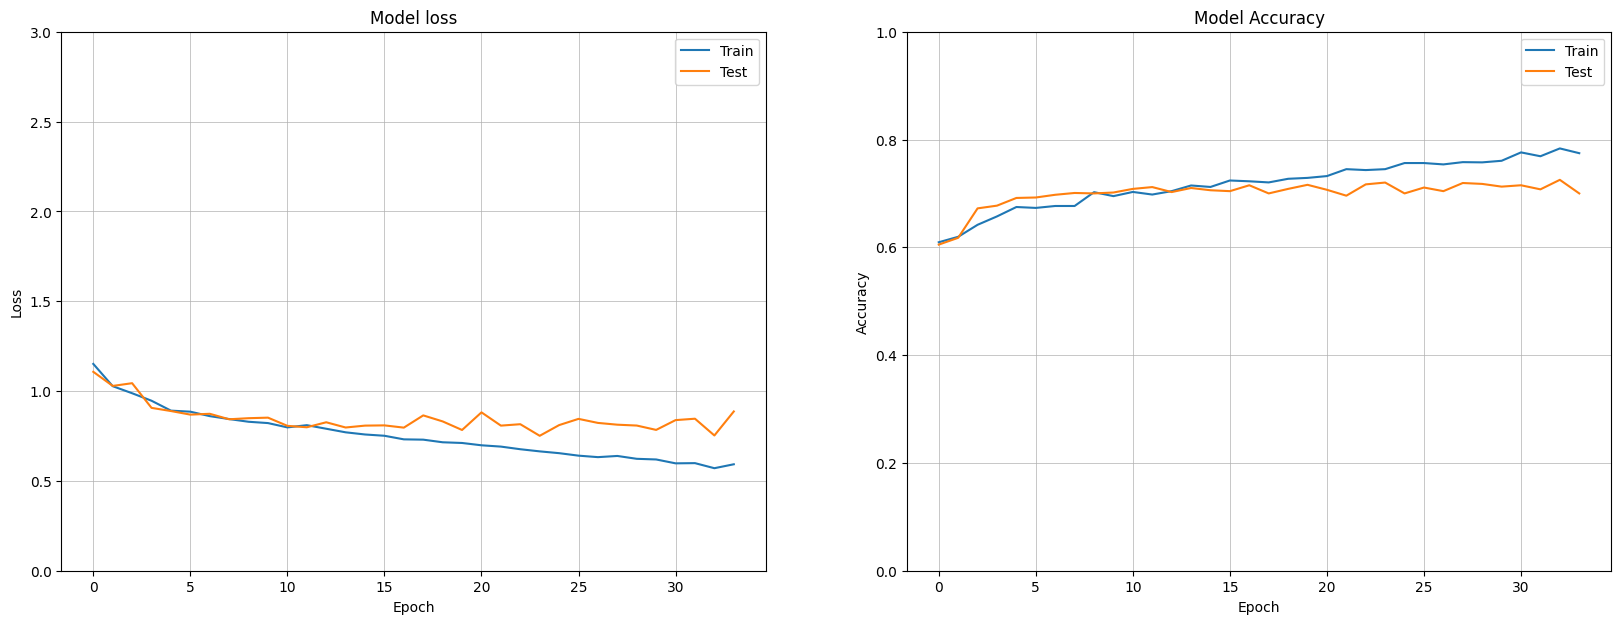

In [146]:
plot_loss_accuracy(history_padding)